In [1]:
import os
os.chdir('..')
metadata_path = 'big_data/metadata_20-05-28.csv'

In [2]:
import datetime
data_datetime = datetime.datetime(2020, 5, 28)

# Packages and presets

In [3]:
import gensim

# for preprocessing
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer

# for bigrams
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from nltk.stem.porter import *
import nltk

# nltk.download('wordnet')
from nltk.corpus import wordnet
from gensim import corpora, models
from pprint import pprint

# auxiliary
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)
import copy
# !date

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Functions

In [4]:
import nlp.preprocessing as prep

dpi = 300 # figure resolution

# Load, preprocess data

In [5]:
df = pd.read_csv(metadata_path)
df = df[pd.isnull(df['abstract']) == False].reset_index(drop=True)

C:\Users\vldoa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df = df[df['abstract'].str.lower().str.contains(
     "covid-19|coronavirus|coronavirus|corona virus|2019-ncov|sars-cov|mers-cov|severe acute respiratory syndrome|middle east respiratory syndrome") | 
         df['abstract'].str.contains("MERS")
         ]

In [7]:
covid_article_indexes = np.argwhere(np.array(df['abstract'].str.contains('COVID|2019-nCoV|SARS-CoV-2'))).T[0]
df['abstract_COVID'] = df['abstract'].str.contains('COVID|2019-nCoV|SARS-CoV-2')
mers_article_indexes = np.argwhere(np.array(df['abstract'].str.contains('MER|middle east| Middle East'))).T[0]
sars_article_indexes = np.argwhere(np.array(df['abstract'].str.contains('SARS'))).T[0]
df['abstract'] =df['abstract'].str.lower()
df['abstract'] = df['abstract'].str.replace('[^\w\s]','')
df.reset_index(drop=True, inplace=True)

In [8]:
count = sum(df['abstract_COVID'] )
count

18412

# NLP Gensim

**Notes**: Working LDA guide pulled from this website (https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24 ). Sklearn's LDA perplexity metric has a bug that makes it unusable.

## Data prep

In [9]:
# function to perform lemmatize and stem preprocessing steps on the data set.
preprocessor = prep.Preprocessor(df['abstract'])
preprocessor.preprocess(lemmatize=True, stopwords=['abstract'], min_token_length=3)

In [10]:
preprocessor.get_bigrams_from_preprocessed()

In [11]:
preprocessor.create_nlp_items_from_preprocessed_df(no_below=2, verbose=True)

dictionary, bow_corpus, tfidf, corpus_tfidf, tfidf_sparse = (preprocessor.dictionary_,
                                                             preprocessor.bow_corpus_,
                                                             preprocessor.tfidf_,
                                                             preprocessor.corpus_tfidf_,
                                                             preprocessor.tfidf_sparse_)

0 activ
1 antigen
2 basi
3 bind_neisseria
4 ceacam
5 ceacam_homophil
6 compos_iglik
7 crystal_structur
8 discuss
9 domain
10 encompass_virusbind

 221637 unique words. 

81450 unique words after extremes filtered. 


Word 0 ("activ") appears 3 time.
Word 26 ("protein") appears 1 time.
Word 64 ("molecular") appears 1 time.
Word 81 ("studi") appears 2 time.
Word 115 ("examin") appears 2 time.
Word 122 ("group") appears 1 time.
Word 144 ("patient") appears 4 time.
Word 145 ("peopl") appears 1 time.
Word 148 ("popul") appears 2 time.
Word 157 ("respiratori_syndrom") appears 1 time.
Word 161 ("sar") appears 1 time.
Word 162 ("screen") appears 2 time.
Word 165 ("select") appears 1 time.
Word 169 ("signific") appears 1 time.
Word 173 ("suscept") appears 2 time.
Word 180 ("test") appears 1 time.
Word 190 ("chang") appears 2 time.
Word 209 ("identifi") appears 1 time.
Word 217 ("measur") appears 1 time.
Word 259 ("differ") appears 1 time.
Word 271 ("inhibitor") appears 1 time.
Word 367 ("detect

## Topic model testing

In [12]:
bow_corpus_np = np.array(bow_corpus)

In [13]:
def cross_validate_topic_models(bow_corpus_np, dictionary, topic_range, n_splits):
    from gensim.models.coherencemodel import CoherenceModel
    # Cross-validate perplexity
    perplexities, coherences = [], []
    for n in topic_range:
        splits = np.random.choice(range(n_splits), size=len(bow_corpus_np))

        perplexities_n, coherences_n = [], []
        print(n)
        for s in range(n_splits):
            training = bow_corpus_np[np.argwhere(splits != s).T[0]]
            test = bow_corpus_np[np.argwhere(splits == s).T[0]]

            lda_model = gensim.models.LdaMulticore(
                            training, num_topics=n,
                            id2word=dictionary, passes=2
                        )
            
            perplexity = lda_model.log_perplexity(test)
            cm = CoherenceModel(model=lda_model, texts=test, dictionary=dictionary, coherence='c_v')
            coherence = cm.get_coherence()

            perplexities_n.append(perplexity); coherences_n.append(coherence)
            print('-')
            
        perplexities.append(perplexities_n); coherences.append(coherences_n)
        print('Perplexities: ' + str(np.mean(perplexities_n)) + ' +/- ' + 
              str(np.std(perplexities_n) / n_splits ** 0.5))
        print('Coherences: ' + str(np.mean(coherences_n)) + ' +/- ' + 
              str(np.std(coherences_n) / n_splits ** 0.5))

    return np.array(perplexities), np.array(coherences)

In [244]:
min_topics = 5
max_topics = 100
step = 10
topic_range = range(min_topics, max_topics, step)

In [245]:
perplexities2, coherences2 = cross_validate_topic_models(bow_corpus_np=bow_corpus_np,
                                     dictionary=dictionary,
                                     topic_range=topic_range,
                                     n_splits=5
                                    )

5


/anaconda3/lib/python3.6/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:202: RuntimeWarning: invalid value encountered in true_divide
  numerator = (co_occur_count / num_docs) + EPSILON
/anaconda3/lib/python3.6/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:203: RuntimeWarning: invalid value encountered in true_divide
  denominator = (w_prime_count / num_docs) * (w_star_count / num_docs)
/anaconda3/lib/python3.6/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:198: RuntimeWarning: invalid value encountered in true_divide
  co_doc_prob = co_occur_count / num_docs


-
-


KeyboardInterrupt: 

In [16]:
def plot_error_bounded_scores(scores, x):
    mean = np.mean(scores, axis=1)
    stdev = np.std(scores, axis=1) / (scores.shape[1] * 0.5)
    mean_plus = mean + stdev; mean_minus = mean - stdev
    n_topics_index = np.array(list(range(len(mean)))) + 1

    fig, ax = plt.subplots()
    ax.plot(x, mean)
    ax.plot(x, mean_plus, c='black')
    ax.plot(x, mean_minus, c='black')


    ax.plot([min_topics, max_topics], [max(mean), min(mean)])
    return mean, stdev, fig, ax

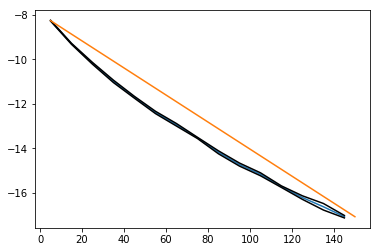

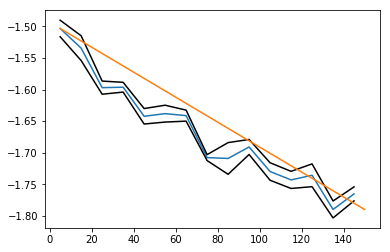

In [20]:
# Num of Topic ranging from 2 to 10
_, _, fig, ax = plot_error_bounded_scores(perplexities2, topic_range)
plt.show()

_, _, fig, ax = plot_error_bounded_scores(coherences2, topic_range)
plt.show()

## Topic model fitting

In [13]:
np.random.seed(25)

n_topics = 30

lda_model = gensim.models.LdaMulticore(
                bow_corpus_np, num_topics=n_topics,
                id2word=dictionary, passes=2, workers=4, eval_every=1
            )

In [14]:
topic_words = []
n_top_words = 10

for i in range(n_topics):
    tt = lda_model.get_topic_terms(i,n_top_words)
    topic_words.append([dictionary[pair[0]] for pair in tt])
    
for e, i in enumerate(topic_words):
    print(e)
    print(i)
lda_model.print_topics(num_words=n_top_words)

0
['patient', 'covid', 'pandem', 'diseas', 'nurs', 'infect', 'coronavirus', 'care', 'ncov', 'treatment']
1
['protein', 'coronavirus', 'virus', 'sarscov', 'cell', 'infect', 'viral', 'studi', 'structur', 'express']
2
['infect', 'covid', 'patient', 'cell', 'virus', 'activ', 'pandem', 'sar', 'coronavirus', 'diseas']
3
['pdcov', 'infect', 'protein', 'coronavirus', 'virus', 'strain', 'cell', 'result', 'studi', 'recombin']
4
['coronavirus', 'cell', 'infect', 'activ', 'virus', 'human', 'viral', 'studi', 'cat', 'respons']
5
['sar', 'case', 'infect', 'coronavirus', 'respiratori_syndrom', 'patient', 'virus', 'transmiss', 'sever_acut', 'diseas']
6
['covid', 'sarscov', 'diseas', 'outbreak', 'countri', 'patient', 'studi', 'case', 'result', 'method']
7
['covid', 'diseas', 'mortal', 'associ', 'patient', 'coronavirus', 'infect', 'risk', 'sever', 'hospit']
8
['infect', 'sarscov', 'virus', 'viral', 'diseas', 'coronavirus', 'covid', 'caus', 'develop', 'human']
9
['sarscov', 'covid', 'coronavirus', 'virus'

[(23,
  '0.035*"covid" + 0.027*"case" + 0.017*"death" + 0.014*"number" + 0.014*"data" + 0.012*"infect" + 0.011*"estim" + 0.010*"result" + 0.010*"diseas" + 0.010*"epidem"'),
 (12,
  '0.047*"covid" + 0.014*"pandem" + 0.014*"patient" + 0.013*"risk" + 0.013*"diseas" + 0.012*"test" + 0.007*"increas" + 0.007*"coronavirus" + 0.007*"infect" + 0.006*"associ"'),
 (20,
  '0.073*"patient" + 0.038*"covid" + 0.018*"sever" + 0.018*"diseas" + 0.013*"treatment" + 0.009*"studi" + 0.009*"sarscov" + 0.009*"hospit" + 0.009*"result" + 0.009*"group"'),
 (14,
  '0.049*"patient" + 0.032*"covid" + 0.024*"case" + 0.016*"test" + 0.014*"symptom" + 0.013*"clinic" + 0.013*"infect" + 0.012*"posit" + 0.012*"sarscov" + 0.011*"result"'),
 (4,
  '0.025*"coronavirus" + 0.020*"cell" + 0.017*"infect" + 0.014*"activ" + 0.013*"virus" + 0.009*"human" + 0.008*"viral" + 0.008*"studi" + 0.008*"cat" + 0.008*"respons"'),
 (7,
  '0.041*"covid" + 0.013*"diseas" + 0.012*"mortal" + 0.012*"associ" + 0.011*"patient" + 0.009*"coronavirus"

 # Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

In [31]:
def format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus_np, texts=df['abstract'], increment=0.01):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    checkpoint=0
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
        if i / len(ldamodel[corpus]) > checkpoint:
            checkpoint += increment
            print(checkpoint)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus_np, texts=df['abstract'])

# Format
dominant_topic_30 = df_topic_sents_keywords.reset_index()
dominant_topic_30.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']

# Show
dominant_topic_30

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.07
0.08
0.09
0.09999999999999999
0.10999999999999999
0.11999999999999998
0.12999999999999998
0.13999999999999999
0.15
0.16
0.17
0.18000000000000002
0.19000000000000003
0.20000000000000004
0.21000000000000005
0.22000000000000006
0.23000000000000007
0.24000000000000007
0.25000000000000006
0.26000000000000006
0.2700000000000001
0.2800000000000001
0.2900000000000001
0.3000000000000001
0.3100000000000001
0.3200000000000001
0.3300000000000001
0.34000000000000014
0.35000000000000014
0.36000000000000015
0.37000000000000016
0.38000000000000017
0.3900000000000002
0.4000000000000002
0.4100000000000002
0.4200000000000002
0.4300000000000002
0.4400000000000002
0.45000000000000023
0.46000000000000024
0.47000000000000025
0.48000000000000026
0.49000000000000027
0.5000000000000002
0.5100000000000002
0.5200000000000002
0.5300000000000002
0.5400000000000003
0.5500000000000003
0.5600000000000003
0.5700000000000003
0.5800000000000003
0.5900000000000003
0.60000

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,0,1.0,0.6119,"protein, coronavirus, virus, sarscov, cell, in..."
1,1,1.0,0.6486,"protein, coronavirus, virus, sarscov, cell, in..."
2,2,5.0,0.9295,"sar, case, infect, coronavirus, respiratori_sy..."
3,3,5.0,0.5678,"sar, case, infect, coronavirus, respiratori_sy..."
...,...,...,...,...
35277,35277,15.0,0.5952,"sarscov, coronavirus, merscov, human, virus, r..."
35278,35278,13.0,0.3585,"covid, patient, infect, sarscov, diseas, pande..."
35279,35279,4.0,0.5869,"coronavirus, cell, infect, activ, virus, human..."
35280,35280,5.0,0.4688,"sar, case, infect, coronavirus, respiratori_sy..."


In [45]:
dominant_topic_30['Abstract'] = df['abstract']
dominant_topic_30['abstract_COVID'] = df['abstract_COVID']
dominant_topic_30['abstract_COVID'] = dominant_topic_30['abstract_COVID'].astype(int)
dominant_topic_30['publish_time'] = df['publish_time']

In [46]:
dominant_topic_30

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Abstract,abstract_COVID,publish_time
0,0,1.0,0.6119,"protein, coronavirus, virus, sarscov, cell, in...",ceacam1 is a member of the carcinoembryonic an...,0,2002-05-01
1,1,1.0,0.6486,"protein, coronavirus, virus, sarscov, cell, in...",the key enzyme in coronavirus polyprotein proc...,0,2002-07-01
2,2,5.0,0.9295,"sar, case, infect, coronavirus, respiratori_sy...",background the human leukocyte antigen hla sys...,0,2003-09-12
3,3,5.0,0.5678,"sar, case, infect, coronavirus, respiratori_sy...",background an epidemic of a severe acute respi...,0,2003-09-10
...,...,...,...,...,...,...,...
35277,35277,15.0,0.5952,"sarscov, coronavirus, merscov, human, virus, r...",the major mechanism of antibodymediated neutra...,0,2018-07-10
35278,35278,13.0,0.3585,"covid, patient, infect, sarscov, diseas, pande...",abstract background coronavirus disease covid1...,1,2020-05-20
35279,35279,4.0,0.5869,"coronavirus, cell, infect, activ, virus, human...",coronaviruses covs such as human coronavirus n...,0,2017-10-23
35280,35280,5.0,0.4688,"sar, case, infect, coronavirus, respiratori_sy...",in the current issue of osong public health an...,1,2020-02-29


# Output file 

In [49]:
dominant_topic_30.to_csv("big_data/dominant_topic_30.csv", index=False)

# Visualizations

In [54]:
metadata_dt_analysis = copy.deepcopy(dominant_topic_30)
metadata_dt_analysis['Dominant_Topic'] = metadata_dt_analysis['Dominant_Topic'].fillna(0).astype(int)
metadata_dt_analysis['abstract_COVID'] = metadata_dt_analysis['abstract_COVID'].astype('bool')
print(len(metadata_dt_analysis))


metadata_dt_analysis['converted_datetime'] = pd.to_datetime(metadata_dt_analysis['publish_time'], errors='coerce') # if format fails to parse, return NaT
metadata_dt_analysis = metadata_dt_analysis.sort_values('converted_datetime')
metadata_dt_analysis = metadata_dt_analysis[pd.isnull(metadata_dt_analysis['converted_datetime']) == False] # drop abstracts w/ null
metadata_dt_analysis = metadata_dt_analysis[metadata_dt_analysis['converted_datetime'] <= data_datetime] # 
print(len(metadata_dt_analysis))

35281
35113


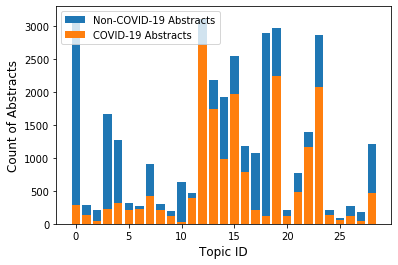

In [56]:
fig, ax = plt.subplots()
plt.bar(np.arange(0, max(metadata_dt_analysis['Dominant_Topic'])),
        np.bincount(metadata_dt_analysis['Dominant_Topic'], minlength=max(metadata_dt_analysis['Dominant_Topic']))[1:], 
        label='Non-COVID-19 Abstracts')
subset_COVID = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID']]
plt.bar(np.arange(0, max(subset_COVID['Dominant_Topic'])),
        np.bincount(subset_COVID['Dominant_Topic'], minlength=max(subset_COVID['Dominant_Topic']))[1:], 
        label='COVID-19 Abstracts')
plt.xlabel('Topic ID', size=12)
plt.ylabel('Count of Abstracts', size=12)
# plt.title('Distribution of Abstracts Across Topics', size=14)
# fig.savefig('Paper/Figures/6.png', dpi=dpi)
plt.legend()

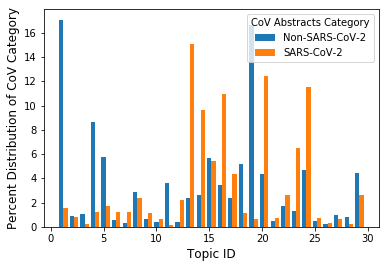

In [59]:
abstract_cnts = np.bincount(metadata_dt_analysis['Dominant_Topic'][metadata_dt_analysis['abstract_COVID'] == 0] ,
                    minlength=max(metadata_dt_analysis['Dominant_Topic'][metadata_dt_analysis['abstract_COVID'] == 0]))[1:]
abstract_cnts = abstract_cnts / sum(abstract_cnts) * 100

fig, ax = plt.subplots()
plt.bar(np.arange(0, max(metadata_dt_analysis['Dominant_Topic'])) + 1,
        abstract_cnts, 
        label='Non-SARS-CoV-2', width=0.4)

abstract_cnts = np.bincount(subset_COVID['Dominant_Topic'], minlength=max(subset_COVID['Dominant_Topic']))[1:]
abstract_cnts = abstract_cnts / sum(abstract_cnts) * 100
subset_COVID = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID']]
plt.bar(np.arange(0, max(subset_COVID['Dominant_Topic'])) + 1 + .4,
        abstract_cnts, 
        label='SARS-CoV-2', width=0.4)
plt.xlabel('Topic ID', size=12)
plt.ylabel('Percent Distribution of CoV Category', size=12)
# plt.title('Distribution of Abstracts Across Topics', size=14)
plt.legend(title='CoV Abstracts Category')
fig.savefig('Paper/Figures/5.png', dpi=dpi)
plt.show()

In [60]:
subset_COVID = metadata_dt_analysis[
    metadata_dt_analysis['abstract_COVID'] &
    (subset_COVID['converted_datetime'] > datetime.datetime(2020, 1, 1))]

C:\Users\vldoa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
topics, c = np.unique(subset_COVID['Dominant_Topic'], return_counts=True)
topics = topics[np.argsort(c)[::-1]]; c = c[np.argsort(c)[::-1]]

n_major = 2
major_topics = topics[0:n_major]

(array([737446., 737456., 737477., 737485., 737506., 737516., 737537.,
        737546., 737567., 737577.]),
 <a list of 10 Text xticklabel objects>)

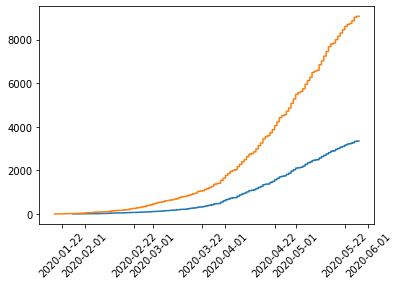

In [62]:

boolean_major_topics = subset_COVID['Dominant_Topic'].isin(major_topics)

y = np.arange(1, sum(boolean_major_topics) + 1)
plt.plot(subset_COVID[boolean_major_topics]['converted_datetime'], y)

y = np.arange(1, sum(boolean_major_topics == False) + 1)
plt.plot(subset_COVID[boolean_major_topics==False]['converted_datetime'], y)
plt.xticks(rotation=45)

# plt.yscale('log')

Biomolecular; other
3, 5, 7, 8, 10, 17
Biomolecular; anti-viral work
16, 22 , 23
Clinical studies
0, 18, 26
Interaction with non-human species
4, 21, 24
Outbreaks
2, 13, 14, 20
Responding to outbreaks
11, 12, 15
Viral detection
19, 25, 27
Other
1, 6, 9, 28, 29

In [69]:
t_outbreak_publichealth = [25, 29, 13, 24, 5]
t_outbreak_reporting = [23, 6, 7, 12, 10, 16, 21]
t_testing = [14, 22]
t_testing_or_transmission = [27, 9]
t_treatments = [0, 20, 17]
t_microbiology_general = [1, 26, 28, 19, 18, 3] # 18 and 3 are each specific but misc. topics
t_microbiology_transmission = [2, 4, 15, 11, 8]
t_microbiology_misc = [18, 3]

t_all = [t_outbreak_publichealth, t_outbreak_reporting, t_testing, t_testing_or_transmission,
         t_treatments, t_microbiology_general, t_microbiology_transmission]
t_all_names = ['Outbreaks, Public Health', 'Outbreaks, General Reporting', 'Testing', 
               'Testing or Transmission', 'Vaccine Needs, Patient Care, and Therapeutics',
               'Microbiology, General', 'Microbiology, Transmission',]

In [70]:
t, c = np.unique(metadata_dt_analysis['Dominant_Topic'][metadata_dt_analysis['abstract_COVID']==True], return_counts=True)
t = t[np.argsort(c)[::-1]]
t

array([13, 20, 24, 16, 14, 23, 15, 17, 22, 29,  8, 12,  5,  1,  0,  4,  7,
        6,  9, 18,  2, 25, 21, 10, 19, 27, 26, 28,  3, 11])

In [71]:
np.sum(metadata_dt_analysis['Dominant_Topic'].isin(t[0:5])) / len(metadata_dt_analysis)

0.3896847321504856

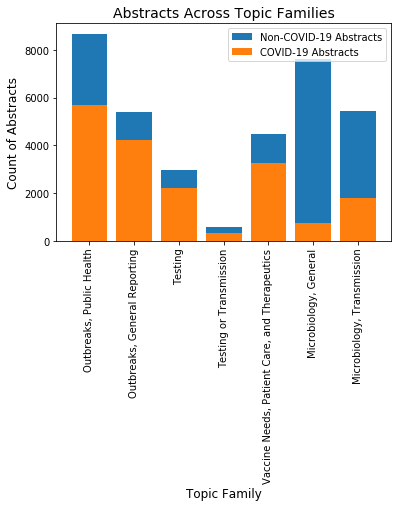

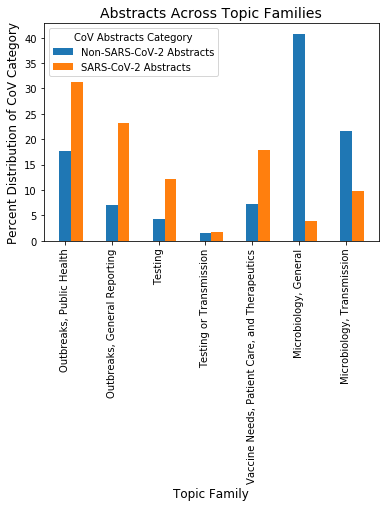

In [72]:
sums_all, sums_covid = [], []
for t, lst in enumerate(t_all):
    boolean = metadata_dt_analysis['Dominant_Topic'].isin(lst)
    sums_all.append(sum(boolean))
    boolean = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID']]['Dominant_Topic'].isin(lst)
    sums_covid.append(sum(boolean))
    
plt.bar(np.arange(0, len(t_all)),
        sums_all, 
        label='Non-COVID-19 Abstracts')
plt.bar(np.arange(0, len(t_all)),
        sums_covid, 
        label='COVID-19 Abstracts')
plt.xticks(np.arange(len(t_all)), t_all_names, rotation=90)
plt.ylabel('Count of Abstracts', size=12)
plt.xlabel('Topic Family', size=12)
plt.title('Abstracts Across Topic Families', size=14)
plt.legend()
plt.show()


## By percentage
sums_all, sums_covid = [], []
for t, lst in enumerate(t_all):
    boolean = metadata_dt_analysis['Dominant_Topic'].isin(lst)
    sums_all.append(sum(boolean))
    boolean = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID']]['Dominant_Topic'].isin(lst)
    sums_covid.append(sum(boolean))
    
sums_all = np.array(sums_all)
sums_covid = np.array(sums_covid)
    
sums_all = sums_all - sums_covid # get non-COVID only
sums_covid = np.array(sums_covid) * 100 / sum(sums_covid)
sums_all = np.array(sums_all) * 100 / sum(sums_all)

    
plt.bar(np.arange(0, len(t_all)),
        sums_all, 
        label='Non-SARS-CoV-2 Abstracts', width=0.25)
plt.bar(np.arange(0, len(t_all)) + 0.25,
        sums_covid, 
        label='SARS-CoV-2 Abstracts', width=0.25)
plt.xticks(np.arange(len(t_all)), t_all_names, rotation=90)
plt.ylabel('Percent Distribution of CoV Category', size=12)
plt.xlabel('Topic Family', size=12)
plt.title('Abstracts Across Topic Families', size=14)
plt.legend(title='CoV Abstracts Category')
plt.show()

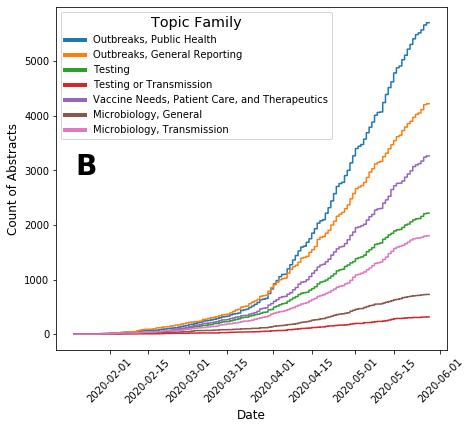

In [73]:
# drop abstracts at 2020 jan 1 due to datetime issues, then normalize later
subset_COVID2 = subset_COVID[subset_COVID['converted_datetime'] > datetime.datetime(2020,1,1)]
norm_factor = len(subset_COVID) / len(subset_COVID2)

sums_all, sums_covid = [], []
fig, ax = plt.subplots(figsize=(7, 7))

covid_normalizer_df = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID']] # use this to normalize cumsums for abstracts with just 2020 as date
x = 0
for t, lst in enumerate(t_all):
    boolean = subset_COVID2['Dominant_Topic'].isin(lst)
    normalize_boolean = covid_normalizer_df['Dominant_Topic'].isin(lst)
    norm_factor = np.sum(normalize_boolean) / np.sum(boolean)
    sums_covid.append(sum(boolean) * norm_factor)
    x += sum(boolean) * norm_factor
    plt.plot(subset_COVID2['converted_datetime'], np.cumsum(boolean) * norm_factor, label = t_all_names[t])
plt.xticks([datetime.datetime(2020, 2, 1), datetime.datetime(2020, 2, 15), 
            datetime.datetime(2020, 3, 1), datetime.datetime(2020, 3, 15), 
            datetime.datetime(2020, 4, 1), datetime.datetime(2020, 4, 15), 
            datetime.datetime(2020, 5, 1), datetime.datetime(2020, 5, 15), 
            datetime.datetime(2020, 6, 1)
           ], rotation=45)

leg = ax.legend(title='Topic Family')
plt.setp(leg.get_title(),fontsize='x-large')
# get the individual lines inside legend and set line width
for line in leg.get_lines():
    line.set_linewidth(4)
    
plt.ylabel('Count of Abstracts', size=12)
plt.xlabel('Date', size=12)
plt.text(0.05, 0.575, 'B', transform=ax.transAxes, fontsize=28, fontweight='bold', va='top')
# plt.title('Topic Families Over Time in COVID-19 Abstracts', size=14)
# plt.yscale('log')
plt.gcf().subplots_adjust(bottom=0.20)
plt.savefig('Paper/Figures/6b.png', dpi=dpi)

In [ ]:
plt.bar(np.arange(0, max(metadata_dt_analysis['Dominant_Topic'])),
        np.bincount(metadata_dt_analysis['Dominant_Topic'], minlength=max(metadata_dt_analysis['Dominant_Topic']))[1:], 
        label='Non-COVID-19 Abstracts')
subset = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID']]
plt.bar(np.arange(0, max(subset['Dominant_Topic'])),
        np.bincount(subset['Dominant_Topic'], minlength=max(subset['Dominant_Topic']))[1:], 
        label='COVID-19 Abstracts')
plt.xlabel('Topic ID', size=12)
plt.ylabel('Count of Abstracts', size=12)
plt.title('Distribution of Abstracts Across Topics', size=14)
plt.legend()

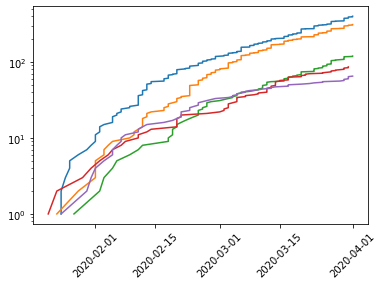

In [97]:
major_topics_n = topics[0:5]
labels = [
    'Public health management',
    'Clinical manifestations',
    'Clinical studies',
    '',
    '',
]

for t in major_topics_n:
    boolean = (subset_COVID['Dominant_Topic'] == t)
    y = np.arange(1, sum(boolean) + 1)
    plt.plot(subset_COVID[boolean]['converted_datetime'], y)

plt.xticks(rotation=45)

plt.yscale('log')

plt.xlabel('Date', size=12)
plt.ylabel('Count of Abstracts (log scale)', size=12)
plt.title('Abstracts Over Time', size=14)
plt.legend()

# COVID Distribution

In [50]:
topics_distribution = dominant_topic_30.groupby(['Dominant_Topic']).agg({'abstract_COVID': 'sum'})

# topic_COVID_presentage = topics_distribution.groupby(level=0).apply(lambda x:
                                                 #100 * x / float(x.count()))
topic_tot = dominant_topic_30.groupby(['Dominant_Topic']).agg({'abstract_COVID': 'count'})

In [51]:
covid_distribution = pd.merge(topics_distribution,topic_tot, on = "Dominant_Topic")

In [52]:
covid_distribution['COVID_Percentage'] = covid_distribution['abstract_COVID_x']/covid_distribution['abstract_COVID_y']

In [53]:
covid_distribution

,abstract_COVID_x,abstract_COVID_y,COVID_Percentage
Dominant_Topic,,,
0.0,150,458,0.327511
1.0,6,43,0.139535
2.0,56,160,0.350000
3.0,75,160,0.468750
...,...,...,...
26.0,407,815,0.499387
27.0,35,640,0.054688
28.0,24,254,0.094488
29.0,5,55,0.090909


In [54]:
covid_distribution.rename(columns={"abstract_COVID_x": "abstract_COVID", "abstract_COVID_y": "total"})

,abstract_COVID,total,COVID_Percentage
Dominant_Topic,,,
0.0,150,458,0.327511
1.0,6,43,0.139535
2.0,56,160,0.350000
3.0,75,160,0.468750
...,...,...,...
26.0,407,815,0.499387
27.0,35,640,0.054688
28.0,24,254,0.094488
29.0,5,55,0.090909


In [55]:
covid_distribution.to_csv("big_data/covid_distribution_30.csv")